# Train deepRetina

In [1]:
# A bit of setup
import numpy as np
from scipy.io import loadmat
import os.path as path
import matplotlib.pyplot as plt
from nems.utilities import rolling_window
from lnl_model_functions import *
from matplotlib.pyplot import *
from pyret.filtertools import getsta, filterpeak # input: (time,), stim (x,x,x,time), spikes (times,)
import pyret.visualizations as viz

# from time import time
# import re
# from os import listdir
# from os.path import isfile, join
# from scipy import misc
# from scipy.stats import pearsonr
# import scipy.io
# import mpld3

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/Library/Frameworks/EPD64.framework/Versions/7.3/lib/python2.7/site-packages/pytz/__init__.py:29: UserWarning: Module IPython was already imported from /Users/lmcintosh/Git/ipython/IPython/__init__.pyc, but /Library/Frameworks/EPD64.framework/Versions/7.3/lib/python2.7/site-packages is being added to sys.path
  from pkg_resources import resource_stream


# Load data

In [2]:
data_dir = '/Users/lmcintosh/Git/deepRGC/datasets/white_noise/'
metadata = np.load(path.join(data_dir, 'metadata.npz'))['metadata'].item()
stim  = np.memmap(path.join(data_dir, 'stim.dat'), dtype=metadata['stim_dtype'], 
                  mode='r', shape=metadata['stim_shape'])
rates = np.memmap(path.join(data_dir, 'rates.dat'), dtype=metadata['rates_dtype'], 
                  mode='r', shape=metadata['rates_shape'])

### Smooth raw spike count with 10 ms std Gaussian to get PSTHs

In [3]:
rates_filt = np.zeros(rates.shape)
filt       = gaussian(x=np.linspace(-5,5,10), sigma=1, mu=0)
for cell in xrange(rates.shape[1]):
    rates_filt[:,cell] = np.convolve(rates[:,cell], filt, mode='same')

### Create 4d stim array where each data point is a 400ms (40 frame) movie

In [14]:
stim_sliced = stim[25:-25, 25:-25,:]

In [18]:
X = rolling_window(stim_sliced, 40)
X = np.rollaxis(X, 2)
X = np.rollaxis(X, 3, 1)

In [21]:
X.shape

(299850, 40, 50, 50)

In [22]:
X.T.shape

(50, 50, 40, 299850)

### Truncate rates to appropriate time frame

In [23]:
y = rates_filt[X.shape[1]:]

### Show STA as sanity check that data looks right

In [25]:
np.mean(y[:,0] > 0)

0.1414807403701851

In [80]:
times = np.linspace(0,0.01*len(rates),len(rates))
X_sta = {}
for cell in xrange(3): #xrange(rt.shape[1]):
    sptimes = times[rt[:,cell] > 0]
    X_sta[cell] = getsta(times, st, sptimes, 40)
    print cell

0
1
2


In [81]:
cell = 2

In [82]:
peak = filterpeak(X_sta[cell][0])

In [83]:
peak

((41, 63, 32), array([63, 41]), 32)

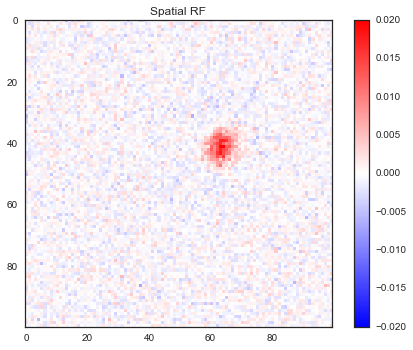

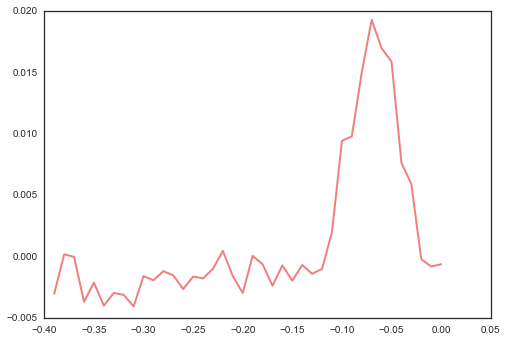

In [94]:
# also viz.playsta
viz.spatial(X_sta[cell][0][:,:,32])
viz.temporal(X_sta[cell][1], X_sta[cell][0][41,63,:])

In [9]:
X.shape

(299850, 40, 100, 100)

In [10]:
y.shape

(299850, 11)

In [29]:
def sta(stimulus, spiketrain):
    if len(spiketrain.shape) > 1:
        nFrames = stimulus.shape[1]
        sta = {}
        for cell in xrange(spiketrain.shape[1]):
            sta[cell] = np.zeros(stimulus[0].shape)
            for spi, sp in enumerate(spiketrain[:,cell]):
                if spi % 100000 == 0:
                        print spi
                        
                if sp == 0:
                    pass
                else:
                    sta[cell] += stimulus[spi]
            print cell
        return sta
            
    else:
        
        numSpikes = len(spiketrain)
        sta = np.dot(stimulus.T, spiketrain)
        sta /= numSpikes
        return sta.T    

In [30]:
X.shape

(299850, 40, 50, 50)

In [31]:
X_sta = sta(X, y[:,:3])

0
100000
200000
0
0
100000
200000
1
0
100000
200000
2


In [33]:
X_sta[0].shape

(40, 50, 50)

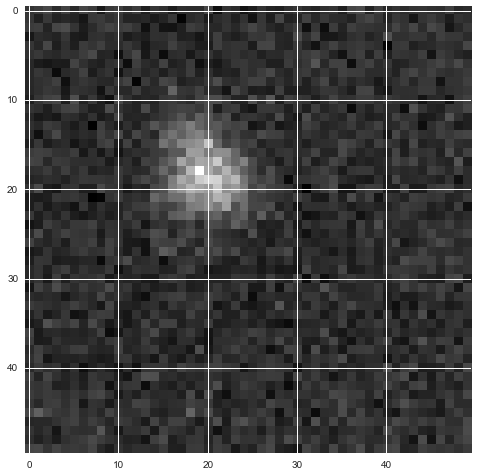

In [37]:
imshow(X_sta[0][30,:,:])

# Train a network

In [75]:
from utils.classifiers.convnet import init_five_layer_convnet
from utils.classifiers.convnet import five_layer_convnet

In [76]:
X[0,:,:,:].shape

(20, 16, 16)

In [77]:
model = init_five_layer_convnet(input_shape=X[0,:,:,:].shape, num_classes=1, filter_sizes=(11,5,5), 
                                  num_filters=(2,2,4,8))

#### For fake data

In [78]:
# Divide examples into training, validation, and test sets
drawIndices = np.random.choice(X.shape[0], size=X.shape[0], replace=False)
trainMask = drawIndices[:len(drawIndices)/2]
valMask   = drawIndices[len(drawIndices)/2:len(drawIndices)/2+len(drawIndices)/4]
testMask  = drawIndices[len(drawIndices)/2+len(drawIndices)/4:]

X_train = X[trainMask]
X_val   = X[valMask]
X_test  = X[testMask]

# Zero-mean the data
mean_img = np.mean(X_train, axis=0)
X_train -= mean_img
X_val -= mean_img
X_test -= mean_img

In [79]:
# move labels into same space as X
y_train = y[trainMask]
y_val   = y[valMask]
y_test  = y[testMask]

#### For real data

In [80]:
# # Since I'm now using PSTHs, we have to restrict the number of examples to a single trial
# X = examples[:spatialWhitePSTH[best_neuron].shape[0]-framesPerExample]
# numExamples = X.shape[0]

# # Divide examples into training, validation, and test sets
# trainMask = np.random.choice(X.shape[0], size=X.shape[0]/2, replace=False)
# valMask   = np.random.choice(X.shape[0], size=X.shape[0]/4, replace=False)
# testMask  = np.random.choice(X.shape[0], size=X.shape[0]/4, replace=False)

# X_train = X[trainMask]
# X_val   = X[valMask]
# X_test  = X[testMask]

# # Zero-mean the data
# mean_img = np.mean(X_train, axis=0)
# X_train -= mean_img
# X_val -= mean_img
# X_test -= mean_img

In [81]:
# # for now choose a neuron
# n = best_neuron

# # move labels into same space as X
# # the following works only when label precision is same as X
# #y = labels[n, framesPerExample:(numExamples+framesPerExample)].astype(int)
# y = spatialWhitePSTH[best_neuron] / np.max(spatialWhitePSTH[best_neuron])
# y = y[framesPerExample:(numExamples+framesPerExample)]

# y_train = y[trainMask]
# y_val   = y[valMask]
# y_test  = y[testMask]

In [82]:
y_train.shape

(5000,)

In [83]:
y_val.shape

(2500,)

In [84]:
X_val.shape

(2500, 20, 16, 16)

## Overtrain a subset

In [90]:
X_train_subset = X_train[:3000]
y_train_subset = y_train[:3000]
X_val_subset   = X_val[:2000]
y_val_subset   = y_val[:2000]

In [91]:
from utils.classifier_trainer import ClassifierTrainer

trainer = ClassifierTrainer()
learning_rate = 5e-3
reg = 0.000
dropout = 1.0
num_epochs = 3

# choose best learning rate from cross validation with 1 epoch
#lr_hist = {} # for lr in logspace(-5,-1,10):
#learning_rate = lr_hist.keys()[np.argmin(lr_hist.values())] # lr of 0.00016681005372000591 for 0.2425 val acc

# choose best regularization from cross validation with 1 epoch
#reg_hist = {} # for r in logspace(-5,-1,10)
#reg = reg_hist.keys()[np.argmin(reg_hist.values())] # r of 0.00016681005372000591 for 0.2425 val acc


best_model = None
best_val_err = np.inf

#for reg in logspace(-5,-1,10):
#for learning_rate in logspace(-4,-1,10):
finetuned_model, loss_history, train_err_history, val_err_history = trainer.train(X_train_subset, y_train_subset, X_val_subset, y_val_subset,
                                model, five_layer_convnet,
                                learning_rate=learning_rate, reg=reg, update='rmsprop',
                                dropout=dropout, num_epochs=num_epochs, batch_size=50,
                                verbose=True)
#print 'Validation error %s for learning rate %s.' %(np.max(val_err_history), learning_rate)
#print 'Validation error %s for regularization %s.' %(np.min(val_err_history), reg)

if np.min(val_err_history) < best_val_err:
    best_model = finetuned_model
    best_val_err = np.min(val_err_history)

#lr_hist[learning_rate] = np.min(val_err_history)
#reg_hist[reg] = np.min(val_err_history)

starting iteration  0
Finished epoch 0 / 3: cost 3.541255, train: 0.319540, val 0.321909, lr 5.000000e-03
starting iteration  10
starting iteration  20
starting iteration  30
starting iteration  40
starting iteration  50
Finished epoch 1 / 3: cost 3.564821, train: 0.315539, val 0.320503, lr 4.750000e-03
starting iteration  60
starting iteration  70
starting iteration  80
starting iteration  90
starting iteration  100
starting iteration  110
Finished epoch 2 / 3: cost 3.602398, train: 0.327897, val 0.320506, lr 4.512500e-03
starting iteration  120
starting iteration  130
starting iteration  140
starting iteration  150
starting iteration  160
starting iteration  170
Finished epoch 3 / 3: cost 3.658302, train: 0.331712, val 0.320524, lr 4.286875e-03
finished optimization. best validation error: 0.320503


In [118]:
print 'Best reg %f, best lr %f.' %(reg_hist.keys()[np.argmin(reg_hist.values())], lr_hist.keys()[np.argmin(lr_hist.values())])

Best reg 0.035938, best lr 0.046416.


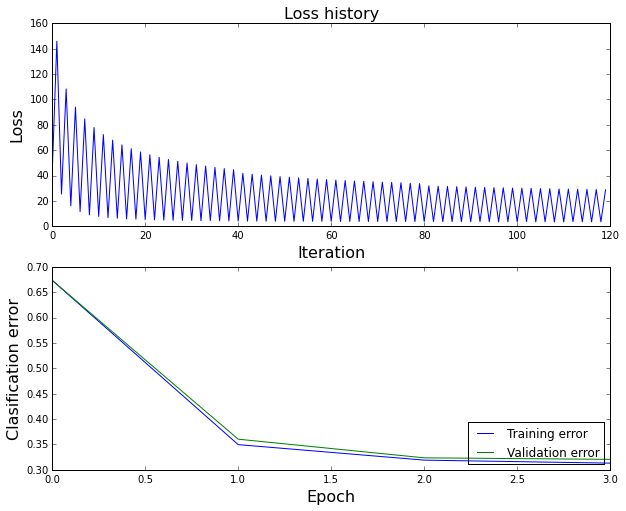

In [87]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(loss_history)
plt.title('Loss history', fontsize=16)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Loss', fontsize=16)
#yscale('log')

ax2 = plt.subplot(2, 1, 2)
plt.plot(train_err_history)
plt.plot(val_err_history)
plt.legend(['Training error', 'Validation error'], loc='lower right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Clasification error', fontsize=16)

# What does the prediction look like?

In [88]:
probs = five_layer_convnet(X_val_subset, finetuned_model, return_probs=True)

In [89]:
plot(np.linspace(0,len(y_val_subset)*precision,len(y_val_subset)), y_val_subset, 'k', linewidth=1)
plot(np.linspace(0,len(y_val_subset)*precision,len(y_val_subset)), probs, 'r', linewidth=4, alpha=.8)
ylabel('Probability of spiking', fontsize=16)
xlabel('Shuffled time (s)', fontsize=16)
mpld3.display()

In [183]:
np.mean(probs)

0.13187999805235004

In [184]:
np.mean(y_train_subset)

0.12382447177247746

# Try with a 3 layer network

In [269]:
from utils.classifiers.convnet import init_three_layer_convnet
from utils.classifiers.convnet import three_layer_convnet

In [270]:
model = init_three_layer_convnet(input_shape=X[0,:,:,:].shape, num_classes=1, filter_size=11,
                                 num_filters=(16,32), weight_scale=.2) # weight_scale was .75, then .1

# Overtrain a subset

In [271]:
X_train_subset = X_train[:3000]
y_train_subset = y_train[:3000]
X_val_subset   = X_val[:2000]
y_val_subset   = y_val[:2000]

In [274]:
from utils.classifier_trainer import ClassifierTrainer

trainer = ClassifierTrainer()
learning_rate = 1e-3
reg = 0.001 #0.001
dropout = None
num_epochs = 5

# choose best learning rate from cross validation with 1 epoch
#lr_hist = {} # for lr in logspace(-5,-1,10):
#learning_rate = lr_hist.keys()[np.argmin(lr_hist.values())] # lr of 0.00016681005372000591 for 0.2425 val acc

# choose best regularization from cross validation with 1 epoch
#reg_hist = {} # for r in logspace(-5,-1,10)
#reg = reg_hist.keys()[np.argmin(reg_hist.values())] # r of 0.00016681005372000591 for 0.2425 val acc


best_model = None
best_val_acc = 0.0 # np.inf

#for reg in logspace(-5,-1,10):
#for learning_rate in logspace(-4,-1,10):
finetuned_model, loss_history, train_acc_history, val_acc_history = trainer.train(X_train_subset, y_train_subset,
                                                                                  X_val_subset, y_val_subset,
                                                                                  model, three_layer_convnet,
                                                                                  learning_rate=learning_rate, 
                                                                                  reg=reg, update='rmsprop',
                                                                                  dropout=dropout, 
                                                                                  num_epochs=num_epochs, 
                                                                                  batch_size=50, verbose=True)
#print 'Validation error %s for learning rate %s.' %(np.max(val_err_history), learning_rate)
#print 'Validation error %s for regularization %s.' %(np.min(val_err_history), reg)

if np.max(val_acc_history) > best_val_acc:
    best_model = finetuned_model
    best_val_acc = np.max(val_acc_history)

#lr_hist[learning_rate] = np.min(val_err_history)
#reg_hist[reg] = np.min(val_err_history)

starting iteration  0
Finished epoch 0 / 5: cost 11369.292322, train: 0.117589, val 0.035570, lr 1.000000e-03
starting iteration  10
starting iteration  20
starting iteration  30
starting iteration  40
starting iteration  50
Finished epoch 1 / 5: cost 8063.397869, train: 0.154910, val 0.038147, lr 9.500000e-04
starting iteration  60
starting iteration  70
starting iteration  80
starting iteration  90
starting iteration  100
starting iteration  110
Finished epoch 2 / 5: cost 6270.394570, train: 0.276602, val 0.032032, lr 9.025000e-04
starting iteration  120
starting iteration  130
starting iteration  140
starting iteration  150
starting iteration  160
starting iteration  170
Finished epoch 3 / 5: cost 4944.920341, train: 0.320807, val 0.056095, lr 8.573750e-04
starting iteration  180
starting iteration  190
starting iteration  200
starting iteration  210
starting iteration  220
starting iteration  230
Finished epoch 4 / 5: cost 3946.310758, train: 0.376468, val 0.086438, lr 8.145062e-04

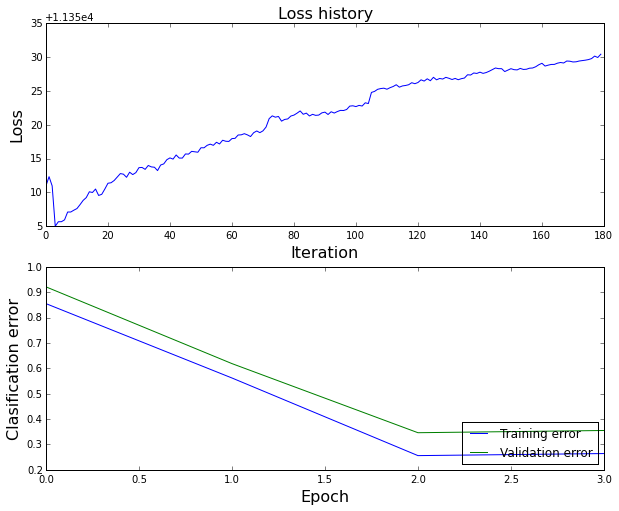

In [180]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(loss_history)
plt.title('Loss history', fontsize=16)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Loss', fontsize=16)
#yscale('log')

ax2 = plt.subplot(2, 1, 2)
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Correlation coefficient', fontsize=16)

In [185]:
#probs = three_layer_convnet(X_train_subset, finetuned_model, return_probs=True)
sub = 500 # len(y_train_subset)
plot(np.linspace(0,sub*precision,sub), y_train_subset[:sub], 'k', linewidth=1)
plot(np.linspace(0,sub*precision,sub), probs[:sub], 'r', linewidth=4, alpha=.8)
ylabel('Probability of spiking', fontsize=16)
xlabel('Shuffled time (s)', fontsize=16)
mpld3.display()

In [182]:
corrcoef(probs.squeeze(), y_train_subset)

array([[ 1.        ,  0.78943008],
       [ 0.78943008,  1.        ]])

In [183]:
pearsonr(probs.squeeze(), y_train_subset)

(0.78943008404557791, 0.0)

In [238]:
probs = three_layer_convnet(X_val_subset, finetuned_model, return_probs=True)
sub = 100 # len(y_val_subset)
plot(np.linspace(0,sub*precision,sub), y_val_subset[:sub], 'k', linewidth=1)
plot(np.linspace(0,sub*precision,sub), probs[:sub], 'r', linewidth=4, alpha=.8)
ylabel('Probability of spiking', fontsize=16)
xlabel('Shuffled time (s)', fontsize=16)
mpld3.display()

In [239]:
scores = three_layer_convnet(X_val_subset, finetuned_model, return_probs=False)